**Описание проекта**
Вы аналитик популярного сервиса аренды самокатов GoFast. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением.

Сервисом можно пользоваться:

без подписки:
- абонентская плата отсутствует;
- стоимость одной минуты поездки — 8 рублей;
- стоимость старта (начала поездки) — 50 рублей;

с подпиской Ultra:
- абонентская плата — 199 рублей в месяц;
- стоимость одной минуты поездки — 6 рублей;
- стоимость старта — бесплатно.

## Шаг 1. Загрузка данных

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from math import *
from scipy.stats import binom,norm

In [2]:
# Таблица с информацией о пользователях
data_user = pd.read_csv('/datasets/users_go.csv')
# Таблица с информацией о поездках
data_rider = pd.read_csv('/datasets/rides_go.csv')
# Таблица с информацией о подписке
data_sub = pd.read_csv('/datasets/subscriptions_go.csv')

In [3]:
# изучим таблицу о пользователях
print(data_user.info())
data_user.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
None


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
# изучим таблицу о поездках
print(data_rider.info())
data_rider.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
None


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [5]:
# изучим таблицу о подписке
print(data_sub.info())
data_sub.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes
None


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


**Вывод:**
Добавили 3 дата фрейма. В дальнейшем надо будет проверить на пропуски и дубликаты. Объеденить 3 таблицы в одну и изменить типы данных некоторых столбцов

## Шаг 2. Предобработка данных

### Приведите столбец date к типу даты pandas

In [6]:
# изменим тип столбца с датой
data_rider['date'] = data_rider['date'].astype("datetime64[ns]")
data_rider['date'].head()

0   2021-01-01
1   2021-01-18
2   2021-04-20
3   2021-08-11
4   2021-08-28
Name: date, dtype: datetime64[ns]

### Создайте новый столбец с номером месяца на основе столбца date.

In [7]:
data_rider['month'] = data_rider['date'].dt.month
data_rider.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


### Проверьте наличие пропущенных значений и дубликатов в датафреймах

In [8]:
# ищем дубликаты
print(data_rider.duplicated().sum())
print(data_user.duplicated().sum())
data_sub.duplicated().sum()

0
31


0

In [9]:
# удаляем найденые дубликаты
data_user = data_user.drop_duplicates()

In [10]:
# Ищем пропуски
print(data_rider.isna().sum())
print(data_user.isna().sum())
data_sub.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64
user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64


subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

**Вывод** 
Был добавлен новый столбец с номером месяца.
Убрали дубликаты и проверили на пропуски.

## Шаг 3. Исследовательский анализ данных

Опишите и визуализируйте общую информацию о пользователях и поездках:
3.1 частота встречаемости городов;
3.2 соотношение пользователей с подпиской и без подписки;
3.3 возраст пользователей;
3.4 расстояние, которое пользователь преодолел за одну поездку;
3.5 продолжительность поездок.

### Частота встречаемости городов

In [11]:
# таблицa со значениями частотности городов
data_user['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

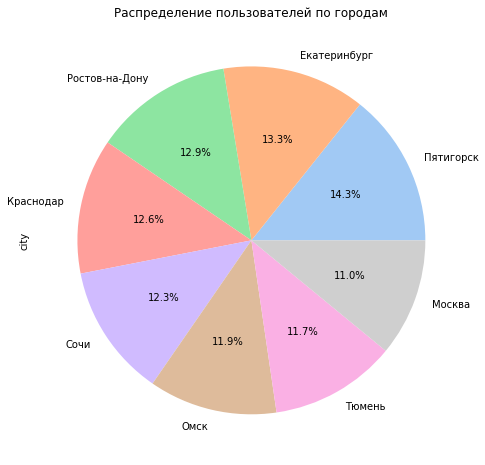

In [12]:
colors = sns.color_palette('pastel')
data_user['city'].value_counts().plot(kind='pie',autopct='%1.1f%%',
                                      figsize=(8,8),colors=colors,
                                      title = 'Распределение пользователей по городам');


Процент встречаемости городов примерно одинаков. Меньше всего пользователей в Москве - 168. Лидирует Пятигорск с 219 пользователями

### соотношение пользователей с подпиской и без подписки

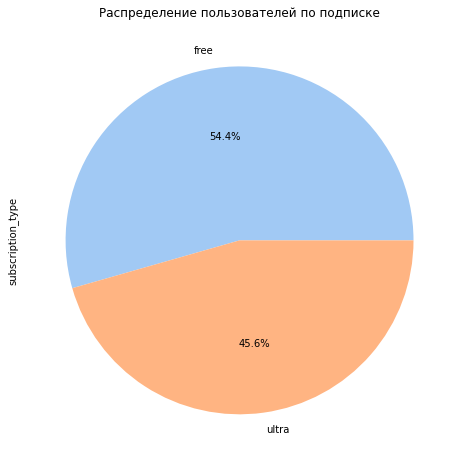

In [13]:
data_user['subscription_type'].value_counts().plot(kind='pie',autopct='%1.1f%%',
                                      figsize=(8,8),colors=colors,
                                      title = 'Распределение пользователей по подписке');

Как мы видим пользователей без подписки больше и составляет 54.4% против 45.6% пользователей с подпиской.

### Возраст пользователей

In [14]:
data_user['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

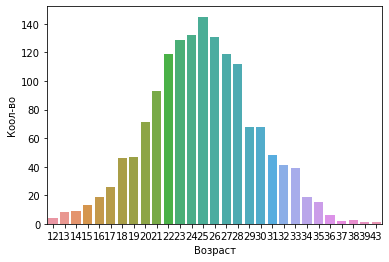

In [15]:
age= data_user.pivot_table(index='age', values='user_id', aggfunc='count');
age.columns=['count']
sns.barplot(data=age, x=age.index, y='count');
plt.xlabel('Возраст');
plt.ylabel('Коол-во');

Как мы видим основная масса пользователей в возрасте от 20 до 30 лет.
Средний восзраст пользователей 25 лет, минимальный 12 лет. Максимальный 43 года.

### Расстояние, которое пользователь преодолел за одну поездку;

In [16]:
data_rider['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

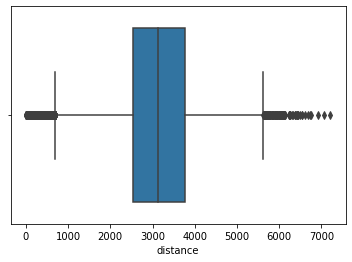

In [17]:

# составим график  дальности поездки
sns.boxplot(data=data_rider, x='distance');

В среднем пользователи за одну поездку преодолевали около 3 километров. Максимальная дистанция 7211 метров, минимальная дистанция меньше метра

### Продолжительность поездок.

In [18]:
data_rider['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

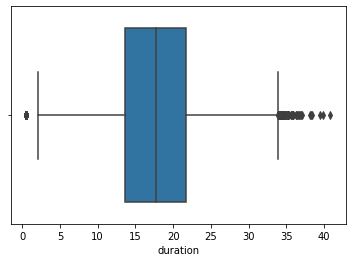

In [19]:
# составим график  длительности поездки
sns.boxplot(data=data_rider, x='duration');

В среднем продолжительность поездок составляет 17 минут. Максимальная длительность - 40 минут, минимальная - 30 секунд

**Вывод:**
- Больше всего пользователей в Пятигорске, меньше всего в Москве.
- Пользователей без подписки больше и составляет 54.4% от общего числа.
- Средний возраст около 25 лет
- Средняя дистанция поездки около 3 км. Максимальная же более 7 км.
- В среднем продолжительность поездки составляет 17 минут.

## Шаг 4. Объединение данных

### Объедините данные о пользователях, поездках и подписках в один датафрейм.

In [20]:
data = data_user.merge(right=data_sub,on='subscription_type')
data = data_rider.merge(right=data, on='user_id')
data

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04,11,Альберт,25,Краснодар,free,8,50,0
18064,1534,2840.423057,21.409799,2021-11-16,11,Альберт,25,Краснодар,free,8,50,0
18065,1534,3826.185507,18.435051,2021-11-18,11,Альберт,25,Краснодар,free,8,50,0
18066,1534,2902.308661,16.674362,2021-11-27,11,Альберт,25,Краснодар,free,8,50,0


### Создайте ещё два датафрейма по типу подписки

In [21]:
# датафрейм с пользователями без подписки
free_data = data.loc[data['subscription_type']== 'free']
free_data

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free,8,50,0
6501,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free,8,50,0
6502,700,4004.434142,20.016628,2021-02-04,2,Айдар,22,Омск,free,8,50,0
6503,700,1205.911290,9.782872,2021-02-10,2,Айдар,22,Омск,free,8,50,0
6504,700,3047.379435,17.427673,2021-02-14,2,Айдар,22,Омск,free,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04,11,Альберт,25,Краснодар,free,8,50,0
18064,1534,2840.423057,21.409799,2021-11-16,11,Альберт,25,Краснодар,free,8,50,0
18065,1534,3826.185507,18.435051,2021-11-18,11,Альберт,25,Краснодар,free,8,50,0
18066,1534,2902.308661,16.674362,2021-11-27,11,Альберт,25,Краснодар,free,8,50,0


In [22]:
# датафрейм с пользователями с подпиской
ultra_data = data.loc[data['subscription_type']== 'ultra']
ultra_data

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,3973.046497,24.671163,2021-08-29,8,Оксана,22,Москва,ultra,6,0,199
6496,699,3288.702563,15.892886,2021-09-12,9,Оксана,22,Москва,ultra,6,0,199
6497,699,3076.159348,14.389525,2021-09-26,9,Оксана,22,Москва,ultra,6,0,199
6498,699,4707.845501,15.839579,2021-10-17,10,Оксана,22,Москва,ultra,6,0,199


### Визуализируйте информацию о расстоянии и времени поездок для пользователей обеих категорий.

In [23]:
free_data['distance'].describe()

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

In [24]:
free_data['duration'].describe()

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

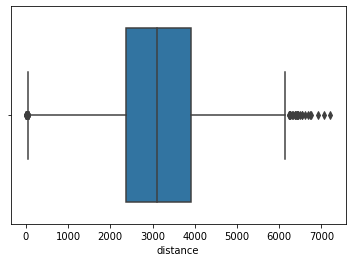

In [25]:
# Визуализация данных по дистанции поездок пользователей без подписки
sns.boxplot(data=free_data, x='distance');

Минимальная дистанция- 0,85 метра, максимальная -7211 метров, средняя дистанция 3045 метров. Выбросы есть с правой и левой сторон.

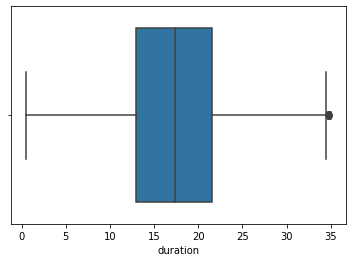

In [26]:
# Визуализация данных по продолжительности поездок пользователей без подписки
sns.boxplot(data=free_data, x='duration');

Минимальная длительность пол минуты, максимальная - 34. Средняя -17 минут

In [27]:
ultra_data['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

In [28]:
ultra_data['duration'].describe()

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

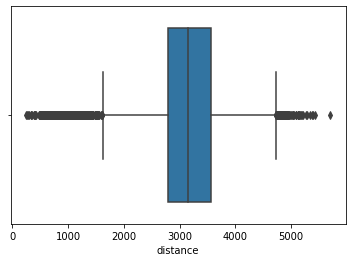

In [29]:
# Визуализация данных по дальности поездок пользователей с подпиской
sns.boxplot(data=ultra_data, x='distance');

Минимальная дистанция- 244 метра, максимальная -5699 метров, средняя дистанция 3115 метров. Выбросы есть с правой и левой сторон.

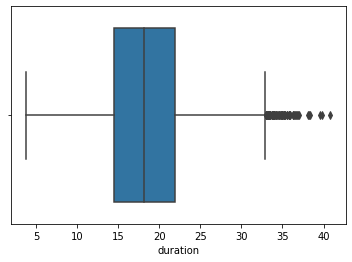

In [30]:
# Визуализация данных по продолжительности поездок пользователей с подпиской
sns.boxplot(data=ultra_data, x='duration');

Минимальная длительность 3 минуты, максимальная - 40. Средняя -18 минут

**Вывод:**
Пользователи с подпиской и без пользуются самокатами одинаково: 
- медиана дистанции у пользователей с подпиской -3148 
- медиана пользователей без подписки -3114.

Длительность поездок в среднем больше у пользователей с подпиской 18 минут, против 17 минут у пользователей без подписки.


## Шаг 5. Подсчёт выручки

###  Создайте датафрейм с агрегированными данными о поездках

In [31]:
# Округлим значения столбца с длительностью до верхнего числа. И здесь же изменим тип данных
data['duration'] = np.ceil(data['duration']).astype(int)

In [32]:
data_revenue=data.pivot_table(index=['user_id', 'month'],
                              values=['distance','duration','subscription_type'],
                              aggfunc={'distance':sum,'duration':[len,np.sum],'subscription_type':max})

data_revenue.columns=['distance','num_trips','duration','subscription_type']
data_revenue

distance  num_trips  duration subscription_type
user_id month                                                     
1       1       7027.511294          2        42             ultra
        4        754.159807          1         7             ultra
        8       6723.470560          2        46             ultra
        10      5809.911100          2        32             ultra
        11      7003.499363          3        56             ultra
...                     ...        ...       ...               ...
1534    6       3409.468534          2        26              free
        8       7622.453034          2        48              free
        9       4928.173852          1        23              free
        11     13350.015305          4        78              free
        12      2371.711192          1        16              free

[11331 rows x 4 columns]

In [33]:
#Изменим тип данных столбца с числом поездок
data_revenue['num_trips'] = data_revenue['num_trips'].astype(int)
data_revenue.head()

distance  num_trips  duration subscription_type
user_id month                                                    
1       1      7027.511294          2        42             ultra
        4       754.159807          1         7             ultra
        8      6723.470560          2        46             ultra
        10     5809.911100          2        32             ultra
        11     7003.499363          3        56             ultra

### Добавление столбца с помесячной выручкой, которую принёс каждый пользователь.

In [34]:
def revenue(row):
    if row['subscription_type'] == 'free':
        start = 50
        minut = 8
        sub = 0
    else :
        start = 0
        minut = 6
        sub = 199
    count =row['num_trips']
    dur = row['duration']
    result = count * start + minut *dur +sub
    return result

In [35]:
data_revenue['revenue'] = data_revenue.apply(revenue, axis=1)
data_revenue

distance  num_trips  duration subscription_type  revenue
user_id month                                                              
1       1       7027.511294          2        42             ultra      451
        4        754.159807          1         7             ultra      241
        8       6723.470560          2        46             ultra      475
        10      5809.911100          2        32             ultra      391
        11      7003.499363          3        56             ultra      535
...                     ...        ...       ...               ...      ...
1534    6       3409.468534          2        26              free      308
        8       7622.453034          2        48              free      484
        9       4928.173852          1        23              free      234
        11     13350.015305          4        78              free      824
        12      2371.711192          1        16              free      178

[11331 rows x 5 columns]

In [36]:
data_revenue=data_revenue.sort_index(level='month')
data_revenue

,,distance,num_trips,duration,subscription_type,revenue
user_id,month,,,,,
1,1,7027.511294,2,42,ultra,451
3,1,3061.777147,1,13,ultra,277
5,1,3914.646990,1,13,ultra,277
7,1,6478.080979,2,28,ultra,367
12,1,3577.151148,1,33,ultra,397
...,...,...,...,...,...,...
1525,12,4597.854350,1,34,free,322
1526,12,3644.121544,1,23,free,234
1528,12,3998.569324,1,11,free,138


Создали новый дата фрейм и добавили столбец с помесячной выручкой каждого пользователя.

**Вывод:**
Был создан новый датафрейм с  агрегированными данными о поездках. Перед этим округлили столбец со временем поездки до большего числа.
Был добавлен новый столбец с помесячной выручкой от каждого пользователя.

## Шаг 6. Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.

### Гипотеза о том, что тратят ли пользователи с подпиской больше времени на поездки.

H0: Длительность поездки с подпиской = длительности поездки без подписки.

H1: Длительность поездки с подпиской > длительности поездки без подписки.

Уровень статистической значимости: 0.05

6500     14.944286
6501     16.234663
6502     20.016628
6503      9.782872
6504     17.427673
           ...    
18063    19.822962
18064    21.409799
18065    18.435051
18066    16.674362
18067    15.893917
Name: duration, Length: 11568, dtype: float64

In [37]:
alpha = 0.05
results = st.ttest_ind(
    ultra_data['duration'],
    free_data['duration'], 
    alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


Гипотеза повредилась. Пользователи с подпиской действительно тратят больше времени на поездки.

### Гипотеза : Что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130.

H0: Среднее растояние которое проезжают пользователи с подпиской за одну поездку = 3130

Н1: Среднее растояние которое проезжают пользователи с подпиской за одну поездку > 3130

Уровень статистической значимости: 0.05

In [38]:
alpha =0.05
group = ultra_data['distance']
dist = 3130

results = st.ttest_1samp(
    group, 
    dist,
    alternative='greater')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 0.9195368847849785
Не отвергаем нулевую гипотезу


Гипотеза  подтвердилась. Среднее расстояние которое проезжают пользователи с подпиской за одну поездку ,меньше или равно 3130 метрам.

### Гипотеза: Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Н0: помесячная выручка от пользователей с подпиской = помесячной выручке от пользователей без подпиской.

Н1: помесячная выручка от пользователей с подпиской > помесячной выручке от пользователей без подпиской.

Уровень статистической значимости: 0.05

In [39]:
alpha = 0.05
fr = data_revenue.loc[data_revenue.subscription_type=='free','revenue']
ul = data_revenue.loc[data_revenue.subscription_type=='ultra','revenue']

results = st.ttest_ind(
    ul,
    fr, 
    alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Можно сделать вывод, что гипотеза подтвердилась. Помесячная выручка от пользователей с подпиской больше.

### Теоритическая задача

 Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

**Ответ**

Мы бы использовали гипотезу о равенстве средних для зависимых (парных) выборок.

В этом случае нам бы понадобился тест - scipy.stats.ttest_rel().Ему надо передать два параметра: наборы данных до и после изменения.

**Вывод:**
Провери 3 гипотезы. Все три потвердились. Решена задача.

## Шаг 7. (необязательное задание). Распределения

### Задача 1

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

/opt/conda/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


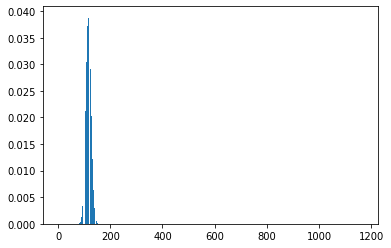

In [40]:

p = 0.1
n = 1165
distr = []

for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)
    
plt.bar(range(0, n + 1), distr);

Вероятность выполнить план состовляет 95%

In [41]:
# Математическое ожидание
u= n*p 
print('Математическое ожидание',u)
# Стандартное отклонение
s= sqrt(n * p *(1-p))
print('Стандартное отклонение', s)

Математическое ожидание 116.5
Стандартное отклонение 10.239628899525608


In [42]:

# задаём нормальное распределение
distr = st.norm(u, s ) 

result =distr.cdf(100)

print(result)

0.0535477514999997


При вероятности не выполнить плана около 5%, нужно разослать не меньше 1160 промокодов

### Задача 2

7.2
 Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 
399,5 тыс. пользователей.

In [43]:
# задаём параметры биномиального распределения
n = 1000000
p = 0.4

# задаём параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))
# задаём нормальное распределение
distr = st.norm(mu, sigma) 


# считаем вероятность 399.5 тысяч
result =distr.cdf(399500)
result

0.15371708296369768

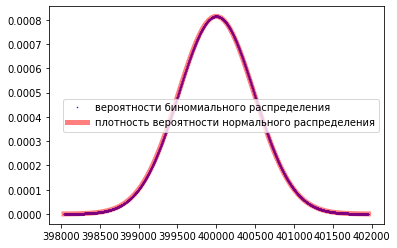

In [44]:

def linspace(start, stop, num):
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result
 

left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))
 

x = list(range(max(0, left), right))
# рисуем график биномиального распределения
ax = plt.subplot();
# используем синие о-образные маркеры и размер маркера 5
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=0.5,label='вероятности биномиального распределения')

# зададим параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))
 

x = linspace(left, right, 100)
# используем красную линию ширины 3 и прозрачности 0.3
ax.plot(x, norm.pdf(x, mu, sigma), 'r-', lw=5, alpha=0.5, label='плотность вероятности нормального распределения')
ax.legend(loc='best') 
plt.show()

Вероятность получить неболее 399,5 тысячи открытий состовляет 15%

##  Общий вывод

Было проведено исследование сервиса аренды самокатов GoFast.
Проведен анализ данных:
- Узнали, что все города в дата фрейме встречаются +- одинаковой частотой.Меньше всего пользователей в Москве - 168. Лидирует Пятигорск с 219 пользователями
- Выяснили, что пользователей с подпиской на 8,8% меньше чем пользователей без подписки.
- Средний возраст пользователей 25 лет.
- Средняя дистанция одной поездки 3 км.
- Средняя длительность поездки 17 минут.

Были проверены три гипотезы:
1. Гипотеза о том, что тратят ли пользователи с подпиской больше времени на поездки
- Гипотеза подтвердилась. Пользователи с подпиской действительно тратят больше времени на поездки.
2. Гипотеза: Что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130.
- Гипотеза  подтвердилась. Среднее расстояние которое проезжают пользователи с подпиской за одну поездку ,меньше или равно 3130 метрам.
3. Гипотеза: Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.
- Гипотеза подтвердилась. Помесячная выручка от пользователей с подпиской больше.
